# Phase-Amplitude Coupling Signal Generator

#### Written by: David C.C. Lu

This section describes the signal generator used for simulating a phase-amplitude coupled signal for use in developing the algorithm for quantifying PAC. For this example, I will use the PAC value of [0.0, 0.5, 1.0], in order to see the progression of signal as PAC changes. Biologically, a phase-amplitude coupled signal typically occur at the trouph of the low frequencied signal. In this signal generator, the amplitude enveloped signal modulates at a 180 degree phase lagged of the phase-giving signal.

### Objective
The objective of this notebook is to first demonstrate the generation of a phase-amplitude coupled signals. The basic form of this signal is stored in the variable `sig['pac_mod']`. Any other signals generated are used to test the performance of the PAC algorithms in ___.

## Overview

* [Signal Generator Parameters](#params)
    * [Signal Generator 1](#sig_gen_1)
    * [Signal Generator 2](#sig_gen_2)
    * [Generate Signal Noise](#noise_gen)
    
    
* [Appendix](#appendix)
    * [Organizing Data into MNE-Python](#mne_data)
    * [Organizing Data into DataFrame](#dataframe)
    * [Save to .csv](#save)
    * [Animate Result](#animate)
    

* [References](#references)

In [1]:
# Import all system modules
import os
import time

import pandas
import numpy as np
from pyfftw.interfaces.numpy_fft import fft, irfft, fftfreq

import mne

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from animate.gif_animate import animate

<a id=params></a>
## Signal Generator Parameters

In [2]:
# Signal Parameters
t_dur = 8                      # time duration of the signal in seconds
Fs = 2**14                     # sampling rate in Hz
N = Fs * t_dur                 # number of samples in the signal
t = np.linspace(0,t_dur,N).reshape(N, 1) # time points of the signal

# For Plotting
t_sec = 0.5 

# For Animations
pacs_specified = np.linspace(0,1,11)
fmod_specified = np.linspace(10,21,11)
phas_specified = np.linspace(150,260,11) * (np.pi/180)

f_ph = np.linspace(14, 25, 11)
f_am = np.linspace(120, 140, 11)

pacs_specified = np.atleast_2d(pacs_specified)
fmod_specified = np.atleast_2d(fmod_specified)
phas_specified = np.atleast_2d(phas_specified)
f_ph = np.atleast_2d(f_ph)
f_am = np.atleast_2d(f_am)

f_width = np.linspace(0.01,0.25,11)
f_mod2 = np.linspace(5,30,11)

f_width = np.atleast_2d(f_width)
f_mod2 = np.atleast_2d(f_mod2)

<a id=sig_gen_1></a>
### Signal Generator 1

In [3]:
def pacgen1(t, pac, fp=None, fa=None, pp_lag=None, pa_lag=np.pi, fmod=None):
    """
    Generating a simple PAC signal.
    The amplitude envelop is a sinusoidal.
    """
    # Signal Generator
    sigp = np.sin( 2 * np.pi * fp * t )
    moda = np.sin( 2 * np.pi * fmod * t + pa_lag)
    moda = moda.reshape(t.size, moda.size // t.size)
    
    ampa = 0.25 * (pac * moda + 2 - pac)
    
    siga = ampa * (np.sin(2 * np.pi * fa * t))  # amplitude-envelop signal

    return siga + sigp

# Organizing for use in dataframe
sig = {
    'pac_mod': pacgen1(t, pacs_specified, fp=16, fa=130, fmod=16),
    'frq_mod': pacgen1(t, .8, fp=16, fa=130, fmod=fmod_specified),
    'pha_mod': pacgen1(t, .8, fp=16, fa=130, fmod=16, pa_lag=phas_specified),
    'frq_var': pacgen1(t, .8, fp=f_ph, fa=f_am, fmod=f_ph)
}

<a id=sig_gen_2></a>
### Signal Generator 2

In [4]:
def pacgen2(t, fp=None, fa=None, md_w=1, md_f=None):
    w_inv = 1 / md_w
    sigp = np.sin( 2 * np.pi * fp * t +180) # phase-giving signal
    amps = []

    def gaussian(x, mu=0, sigma=0.1):
        g = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
        return g/np.max(g)

    for c in np.arange(t.flatten()[0], t.flatten()[-1], 1 / md_f):
        amps += [gaussian(t, mu=c + (1 / md_f) / 4, sigma=(1 / md_f) / (w_inv))]
    
    ampa = 0.5 * np.sum(amps, axis=0)
    siga = ampa * np.sin(2 * np.pi * fa * t)  # amplitude-envelop signal
    
    return siga + sigp
    
# Organizing for use in dataframe
tmp = pacgen2(t, fp=16, fa=130, md_w=f_width, md_f=16)
# tmp = pacgen2(t, fp=16, fa=130, md_w=0.1, md_f=f_mod2)
# sig['gma'] = np.asarray([pacgen2(t, fp=16, fa=130, md_w=width, md_f=16)['full'] for width in np.linspace(0.01,0.25,11)])
# sig['gmb'] = np.asarray([pacgen2(t, fp=16, fa=130, md_w=0.1, md_f=f)['full'] for f in np.linspace(5,30,11)])

<a id=noise_gen></a>
### Generate Signal Noises

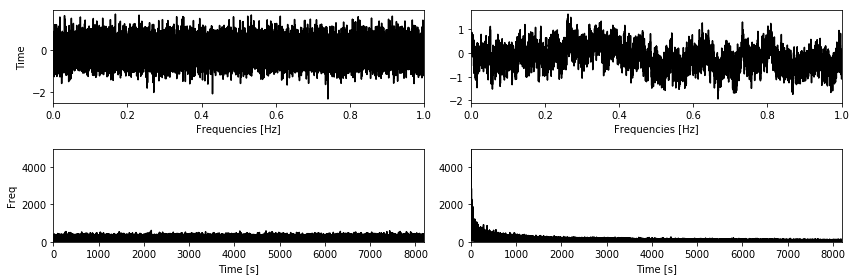

In [5]:
def white_noise(N, amp=.5):
    """
    =================================
    White Noise
    -----------------
    White noise has a constant power density. It's narrowband spectrum is therefore flat.
    The power in white noise will increase by a factor of two for each octave band, 
    and therefore increases with 3 dB per octave.
    =================================
    """
    return amp * np.random.randn(N)

def pink_noise(N, amp=1):
    """
    =================================
    Pink Noise
    -------------------
    Pink noise has equal power in bands that are proportionally wide.
    Power density decreases with 3 dB per octave.
    =================================
    """
    uneven = N % 2
    X = np.random.randn(N//2+1+uneven) + 1j * np.random.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero

    y = (irfft(X/S)).real
    if uneven: y = y[:-1]

    # Normalize the results to the white noise
    return amp * y * np.sqrt((np.abs(white_noise(N))**2.0).mean() / (np.abs(y)**2.0).mean()).real

w = fftfreq(N)
w*=Fs

# Organize the noises into a single variable for easier plot implementations
noise = {}
noise['time'] = {'white':white_noise(N), 'pink':pink_noise(N)}
noise['freq'] = {'white':fft(white_noise(N)), 'pink':fft(pink_noise(N))}

# Plotting Noise
rows = ['time','freq']
noise_c = ['white','pink']
x_data = {'time':t, 'freq':w}
fig_noise, ax_noise = plt.subplots(2,2,figsize=(12,4))
for (ix,jx), ax in np.ndenumerate(ax_noise):
    
    tmpx_t = t[t<=1]
    tmpy_t = noise['time'][noise_c[jx]][t.flatten()<=1]
    
    tmpx_f = w[w>=0]
    tmpy_f = np.abs(noise['freq'][noise_c[jx]])[w>=0]
    
    if ix:
        ax.plot(tmpx_f, tmpy_f, c='k')
        ax.set_xlim([0,Fs/2])
        ax.set_ylim([0,5000])
        ax.set_xlabel('Time [s]')
    else:
        ax.plot(tmpx_t, tmpy_t, c='k')
        ax.set_xlim([0,1])
        ax.set_xlabel('Frequencies [Hz]')
        
    if jx == 0:
        ax.set_ylabel(rows[ix].title())
     
    plt.tight_layout()
    

# Organize into a variable for use in dataframe
sig['white'] = np.atleast_2d(noise['time']['white']).T
sig['pink'] = np.atleast_2d(noise['time']['pink']).T

del tmpx_f, tmpx_t, tmpy_f, tmpy_t

<a id=appendix></a>
# Appendix

<a id=mne_data></a>
### Organizing Data into MNE-Python

In [6]:
ch_names = []
data = np.empty([0,N])
for k in sig.keys():
    tmp_s = np.atleast_2d(sig[k])
    if k not in ['white', 'pink']:
        data = np.vstack([data, sig[k].T])
        for ix in range(tmp_s.shape[-1]):
            ch_names += ['{}-{}'.format(k,ix)]
        
N_ch, Nsamp = data.shape
ch_types = ['eeg'] * N_ch

info = mne.create_info(
    ch_names = ch_names, 
    ch_types = ch_types, 
    sfreq    = Fs
)

print(ch_names)
print(data.shape, len(info["ch_names"]))

['pac_mod-0', 'pac_mod-1', 'pac_mod-2', 'pac_mod-3', 'pac_mod-4', 'pac_mod-5', 'pac_mod-6', 'pac_mod-7', 'pac_mod-8', 'pac_mod-9', 'pac_mod-10', 'frq_mod-0', 'frq_mod-1', 'frq_mod-2', 'frq_mod-3', 'frq_mod-4', 'frq_mod-5', 'frq_mod-6', 'frq_mod-7', 'frq_mod-8', 'frq_mod-9', 'frq_mod-10', 'pha_mod-0', 'pha_mod-1', 'pha_mod-2', 'pha_mod-3', 'pha_mod-4', 'pha_mod-5', 'pha_mod-6', 'pha_mod-7', 'pha_mod-8', 'pha_mod-9', 'pha_mod-10', 'frq_var-0', 'frq_var-1', 'frq_var-2', 'frq_var-3', 'frq_var-4', 'frq_var-5', 'frq_var-6', 'frq_var-7', 'frq_var-8', 'frq_var-9', 'frq_var-10']
(44, 131072) 44


In [7]:
mer_raw = mne.io.RawArray(data, info)

print(mer_raw)

data_path = os.path.join(os.getcwd(), 'data')

if not os.path.isdir(data_path):
    os.makedirs(data_path)
    
mer_raw.save(os.path.join(data_path,'pacgen_raw.fif'), tmin=0, tmax=t_dur,
             overwrite=True)

Creating RawArray with float64 data, n_channels=44, n_times=131072
    Range : 0 ... 131071 =      0.000 ...     8.000 secs
Ready.
<RawArray  |  None, n_channels x n_times : 44 x 131072 (8.0 sec), ~44.1 MB, data loaded>
Overwriting existing file.
Writing /Users/davidlu/Developer/PhD Projects/notes_mspacman/data/pacgen_raw.fif
Closing /Users/davidlu/Developer/PhD Projects/notes_mspacman/data/pacgen_raw.fif [done]


<a id=dataframe></a>
### Organizing Data into DataFrame

In [8]:
col_name = []
data = np.empty([0,N])
for k in sig.keys():
    tmp_s = np.atleast_2d(sig[k])
    if k in ['white', 'pink']:
        col_name += ['{}'.format(k)]
    else:
        for ix in range(tmp_s.shape[-1]):
            col_name+=['{}-{}'.format(k,ix)]
            
    data = np.vstack([data, sig[k].T])

print(col_name)    
print(data.shape)

df = pandas.DataFrame(data.T, index=t.flatten(), columns=col_name)
print(df.head())

['pac_mod-0', 'pac_mod-1', 'pac_mod-2', 'pac_mod-3', 'pac_mod-4', 'pac_mod-5', 'pac_mod-6', 'pac_mod-7', 'pac_mod-8', 'pac_mod-9', 'pac_mod-10', 'frq_mod-0', 'frq_mod-1', 'frq_mod-2', 'frq_mod-3', 'frq_mod-4', 'frq_mod-5', 'frq_mod-6', 'frq_mod-7', 'frq_mod-8', 'frq_mod-9', 'frq_mod-10', 'pha_mod-0', 'pha_mod-1', 'pha_mod-2', 'pha_mod-3', 'pha_mod-4', 'pha_mod-5', 'pha_mod-6', 'pha_mod-7', 'pha_mod-8', 'pha_mod-9', 'pha_mod-10', 'frq_var-0', 'frq_var-1', 'frq_var-2', 'frq_var-3', 'frq_var-4', 'frq_var-5', 'frq_var-6', 'frq_var-7', 'frq_var-8', 'frq_var-9', 'frq_var-10', 'white', 'pink']
(46, 131072)
          pac_mod-0  pac_mod-1  pac_mod-2  pac_mod-3  pac_mod-4  pac_mod-5  \
0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
0.000061   0.031053   0.029799   0.028546   0.027292   0.026039   0.024785   
0.000122   0.062044   0.059525   0.057006   0.054486   0.051967   0.049448   
0.000183   0.092911   0.089117   0.085323   0.081529   0.077736   0.073942   
0.0

In [9]:
for i, k in enumerate(sig.keys()):
    tmp = pandas.DataFrame(sig[k], index=t.flatten(), columns=[[k]*sig[k].shape[-1],np.arange(sig[k].shape[-1])])
    df = pandas.concat([df, tmp], axis=1) if i else tmp
    
df.head()

pac_mod                                                    \
                0         1         2         3         4         5    
0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.000061  0.031053  0.029799  0.028546  0.027292  0.026039  0.024785   
0.000122  0.062044  0.059525  0.057006  0.054486  0.051967  0.049448   
0.000183  0.092911  0.089117  0.085323  0.081529  0.077736  0.073942   
0.000244  0.123591  0.118517  0.113443  0.108369  0.103295  0.098221   

                                                    ...      frq_var  \
                6         7         8         9     ...           3    
0.000000  0.000000  0.000000  0.000000  0.000000    ...     0.000000   
0.000061  0.023532  0.022279  0.021025  0.019772    ...     0.021061   
0.000122  0.046929  0.044410  0.041891  0.039371    ...     0.041960   
0.000183  0.070148  0.066354  0.062561  0.058767    ...     0.062664   
0.000244  0.093147  0.088073  0.082999  0.077925    ...     0.083140   

                                                                      \
                4         5         6         7         8         9    
0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.000061  0.021707  0.022354  0.023000  0.023646  0.024292  0.024938   
0.000122  0.043241  0.044521  0.045801  0.047081  0.048359  0.049637   
0.000183  0.064566  0.066466  0.068366  0.070263  0.072160  0.074055   
0.000244  0.085648  0.088153  0.090656  0.093156  0.095653  0.098148   

                       white      pink  
                10        0         0   
0.000000  0.000000 -0.382705  0.564025  
0.000061  0.025584  0.119200  0.560223  
0.000122  0.050915  0.569142  0.373437  
0.000183  0.075948 -0.201733  0.360795  
0.000244  0.100640 -0.197598  0.114128  

[5 rows x 46 columns]

<a id=save></a>
### Save to .csv

In [10]:
cache_path = os.path.join(os.getcwd(), 'data')
if not os.path.isdir(cache_path):
    os.mkdir(cache_path)

path_to_save = os.path.join(cache_path)
# filename = 'pacgen_'+ ''.join(time.strftime("%x").split('/')) + '.csv'
filename = 'pacgen_raw.csv'

print(path_to_save)
print(filename)

if os.path.isdir(path_to_save):
    df.to_csv(os.path.join(path_to_save,filename), sep='\t', encoding='utf-8')
else:
    os.mkdir(path_to_save)

/Users/davidlu/Developer/PhD Projects/notes_mspacman/data
pacgen_raw.csv


<a id=animate></a>
### Animate Results

<img src='./figures/pac_animate_signals.gif'>

In [11]:
# The codes to generate the animations above
sigF = {k: fft(v, axis=0) for k, v in sig.items()}

count = 0
tidx = (t <= t_sec).flatten()
widx = (w >= 0).flatten()
def animate_signals(frame):
    global count

    if count >= 10:
        i = 10*2-count
    else:
        i = count

    for ix, k in enumerate(sig.keys()):
        if k not in ['white', 'pink']:
            plt.subplot(4,2,2*ix+1)
            plt.cla()

            plt.plot(t[tidx], sig[k][:,i][tidx])

            plt.yticks([])
            plt.ylim([-4,4])
            plt.xlabel('Time [s]', fontsize=20)
            plt.ylabel(k, fontsize=20)

            plt.subplot(4,2,2*(ix+1))
            plt.cla()

            plt.plot(w[widx], np.abs(sigF[k][:,i][widx]))

            plt.yticks([])
            plt.xlabel('Frequencies [Hz]', fontsize=20)
            plt.xlim([0,200])

    plt.tight_layout()
        
    count+=1

if not os.path.isdir(os.path.join(cache_path, '..', 'figures')):
    os.mkdir(os.path.join(cache_path, '..', 'figures'))

# animate('./figures/pac_animate_signals.gif', animate_signals, \
#         20, 200, figsize=(12, 12))

<a id=references></a>
# References

[1] A. B. L. Tort, R. Komorowski, H. Eichenbaum, and N. Kopell, “Measuring Phase-Amplitude Coupling Between Neuronal Oscillations of Different Frequencies,” J. Neurophysiol., vol. 104, no. 2, pp. 1195–1210, 2010. [Online]. Available: http://jn.physiology.org/cgi/doi/10.1152/jn.00106.2010

[2] B. Pittman-Polletta, W.-H. Hsieh, S. Kaur, M.-T. Lo, and K. Hu, “Detecting phase-amplitude coupling with high frequency resolution using adaptive decompositions,” J. Neurosci. Methods, vol. 226, pp. 15–32, 2014. [Online]. Available: http://linkinghub.elsevier.com/retrieve/pii/S016502701400017X